In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import json
import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
import librosa
from tqdm import tqdm 
import re
import os
import pandas as pd

In [26]:
def max_over_interval(x, interval=1, sample_rate=44100):
    samples_per_segment = int(sample_rate * interval)
    num_segments = x.shape[0] // samples_per_segment  # Ensure integer division
    max_levels = np.max(np.split(x[:num_segments * samples_per_segment], num_segments), axis=1)
    return max_levels

def viz_audio(x, y=None, interval=1, sample_rate=44100,
                      title='Audio Signal', x_legend='Input' , y_legend='Output',
                      figsize=(10, 4)):
 
    max_levels = max_over_interval(x, interval, sample_rate)
    num_segments = max_levels.shape[0]    
    seconds = np.arange(0, num_segments) * interval
    plt.figure(figsize=figsize)
    plt.plot(seconds, max_levels, marker='o')
    if y is not None:
        max_levels_y = max_over_interval(y, interval, sample_rate)
        plt.plot(seconds, max_levels_y, marker='x', color='red')
        plt.legend([x_legend, y_legend])
    plt.xlabel('Time (s)')
    plt.ylabel('Max Amplitude')
    plt.title(f'Maximum Sound Level per {interval:.1f}s Segment')
    plt.grid(True)
    plt.show()

In [27]:

def load_model_from_json(filename, return_sequences=False):
    with open(filename, 'r') as infile:
        model_dict = json.load(infile)

    input_shape = model_dict['in_shape'][1:]  # Skip the None dimension in the input shape
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=input_shape))
    model_info_list = [] 

    for layer_info in model_dict['layers']:
        layer_kwargs = {}  # Arguments to pass to the layer constructor

        # Handling common properties
        activation = layer_info.get('activation', None)
        if 'activation' in layer_info and layer_info['activation']:
            layer_kwargs['activation'] = layer_info['activation']

        # Construct layers based on type
        if layer_info['type'] == 'dense':
            layer = keras.layers.Dense(units=layer_info['shape'][-1], **layer_kwargs)

        elif layer_info['type'] == 'conv1d':
            layer_kwargs.update({
                'filters': layer_info['shape'][-1],
                'kernel_size': layer_info['kernel_size'] if 'kernel_size' in layer_info else 1
            })
            if 'dilation' in layer_info and layer_info['dilation']:
                layer_kwargs['dilation_rate'] = layer_info['dilation']
            if 'groups' in layer_info and layer_info['groups']:
                layer_kwargs['groups'] = layer_info['groups']
            layer = keras.layers.Conv1D(**layer_kwargs)

        elif layer_info['type'] == 'conv2d':
            layer_kwargs.update({
                'filters': layer_info['num_filters_out'],
                'kernel_size': (layer_info['kernel_size_time'], layer_info['kernel_size_feature']),
                'strides': (1, layer_info['strides']) if 'strides' in layer_info else (1, 1),
                'padding': layer_info['padding'] if 'padding' in layer_info else 'valid'
            })
            if 'dilation' in layer_info and layer_info['dilation']:
                layer_kwargs['dilation_rate'] = (layer_info['dilation'], layer_info['dilation'])
            layer = keras.layers.Conv2D(**layer_kwargs)

        elif layer_info['type'] == 'batchnorm' or layer_info['type'] == 'batchnorm2d':
            if 'epsilon' in layer_info:
                layer_kwargs['epsilon'] = layer_info['epsilon']
            layer = keras.layers.BatchNormalization(**layer_kwargs)

        elif layer_info['type'] == 'prelu':
            layer = keras.layers.PReLU()

        elif layer_info['type'] == 'activation':
            layer = keras.layers.Activation(layer_info['activation'])

        elif layer_info['type'] == 'gru' or layer_info['type'] == 'lstm':
            layer_kwargs['units'] = layer_info['shape'][-1]
            layer_kwargs['return_sequences'] = return_sequences 
            if layer_info['type'] == 'gru':
                layer = keras.layers.GRU(**layer_kwargs)
            else:
                layer = keras.layers.LSTM(**layer_kwargs)
                activation = 'tanh/sigmoid'

        elif layer_info['type'] == 'time-distributed-dense':
            inner_layer = keras.layers.Dense(units=layer_info['shape'][-1], **layer_kwargs)
            layer = keras.layers.TimeDistributed(inner_layer)

        else:
            raise ValueError(f"Unknown layer type: {layer_info['type']}")

        model.add(layer)
        if 'weights' in layer_info:
            layer.set_weights([np.array(w) for w in layer_info['weights']])

        model_info_list.append({
            'layer_type': layer_info['type'],
            'size': layer_info['shape'],
            'param_count': layer.count_params(),
            'activation': activation
        })

    return model, model_info_list


# Building the results table for the list of audio models we tested

In [28]:
# get all models in results-approx folder and subfolders

results_dir = '../results-approx/models/'
model_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file.endswith('.json'):
            model_files.append(os.path.join(root, file))


# Initialize a list to store model data
models = []

for model_file in model_files:
    # Load model and retrieve model info
    model, model_info = load_model_from_json(model_file, return_sequences=False)
    model_name = re.search(r'(?<=results-approx/models/).*(?=.json)', model_file).group()
    model_params = model.count_params()
    
    layers = [info['layer_type'] for info in model_info]
    sizes = [max([int(d) for d in info['size'] if d]) for info in model_info]
    # Prepare a dictionary to hold all model data
    model_data = {
        'name' : model_name.replace('\\','/').replace('_', '\_'),
        # 'source': model_name.split('/')[-2],
        # 'name': model_name.split('/')[-1].replace('_', '\_'),
        'total params': model_params,
        'layers': str([f'{t}-{s}' for t,s in zip(layers, sizes)]).replace('(','').replace(')','').replace('\'','').replace('[','').replace(']',''),
    }

    # # Flatten layer info into model_data with unique column names
    # for i, info in enumerate(model_info):
    #     model_data[f'layer{i} type'] = info['layer_type']
    #     model_data[f'layer{i} size'] = max([int(d) for d in info['size'] if d])
    #     model_data[f'layer{i} params'] = int(info['param_count'])
    #     model_data[f'layer{i} activation'] = info['activation']

    # Append the model data to the models list
    models.append(model_data)

# Convert list of dictionaries to DataFrame
models_df = pd.DataFrame(models).replace('', np.nan).dropna(axis=1, how='all').fillna('-').sort_values(by='total params', ascending=False)

models_df

name  total params  \
0                                ds/tanh\_3\_256\_tf         66561   
2               MLTerror15/0.85-0.5-0.85-model-gru-6         12929   
4              MLTerror15/0.85-0.85-0.85-model-gru-6         12929   
6                 MLTerror15/0.5-0.5-0.5-model-gru-6         12929   
3                MLTerror15/0.5-0.5-0.5-model-lstm-1          4385   
1                 MLTerror15/0.5-0.5-0.5-model-gru-4          3489   
5               MLTerror15/0.5-0.85-0.85-model-gru-5          3393   
7        aidadsp/tw40\_british\_lead\_deerinkstudios           685   
8   aidadsp/tw40\_california\_crunch\_deerinkstudios           685   
9        aidadsp/tw40\_blues\_deluxe\_deerinkstudios           685   
10         aidadsp/tw40\_blues\_solo\_deerinkstudios           685   
11     aidadsp/tw40\_british\_rhythm\_deerinkstudios           685   
12   aidadsp/tw40\_california\_clean\_deerinkstudios           685   

                           layers  
0   dense-256, dense-256, dense-1  
2                 gru-64, dense-1  
4                 gru-64, dense-1  
6                 gru-64, dense-1  
3                lstm-32, dense-1  
1                 gru-32, dense-1  
5                 gru-32, dense-1  
7                lstm-12, dense-1  
8                lstm-12, dense-1  
9                lstm-12, dense-1  
10               lstm-12, dense-1  
11               lstm-12, dense-1  
12               lstm-12, dense-1

In [29]:
# convert to latex
# print(models_df_merged.to_latex(index=False))


# Here's where we just try to run inference on the models

In [30]:
for i, m in enumerate(model_files):
    print(f"{i}: {m}")

0: ../results-approx/models/ds/tanh_3_256_tf.json
1: ../results-approx/models/MLTerror15/0.5-0.5-0.5-model-gru-4.json
2: ../results-approx/models/MLTerror15/0.85-0.5-0.85-model-gru-6.json
3: ../results-approx/models/MLTerror15/0.5-0.5-0.5-model-lstm-1.json
4: ../results-approx/models/MLTerror15/0.85-0.85-0.85-model-gru-6.json
5: ../results-approx/models/MLTerror15/0.5-0.85-0.85-model-gru-5.json
6: ../results-approx/models/MLTerror15/0.5-0.5-0.5-model-gru-6.json
7: ../results-approx/models/aidadsp/tw40_british_lead_deerinkstudios.json
8: ../results-approx/models/aidadsp/tw40_california_crunch_deerinkstudios.json
9: ../results-approx/models/aidadsp/tw40_blues_deluxe_deerinkstudios.json
10: ../results-approx/models/aidadsp/tw40_blues_solo_deerinkstudios.json
11: ../results-approx/models/aidadsp/tw40_british_rhythm_deerinkstudios.json
12: ../results-approx/models/aidadsp/tw40_california_clean_deerinkstudios.json


In [31]:
# model_file = 'ht1-target_train_colab_guitar_lstm_36.json'
model_file = 'Ben Vox 441 16bit_colab_guitar_lstm_96.json'
# model_file = 'Ben Direct FP_lstm_tf_real_128.json'
# model_file =model_files[-1]

# Let's load the audio file
audio_x_file = 'Ben Direct FP'
# audio_x_file = 'ht1-input_test'
# audio_x_file = 'ht1-input_train'
audio_y_file = 'Ben Vox FP'
# audio_y_file = 'ht1-target_test'
# audio_y_file = 'ht1-target_train'
start_time = 2
seconds_to_predict = 10
keras.backend.clear_session()
model, _ = load_model_from_json(model_file, return_sequences=True)
print(f'loaded model {model_file}   ')
model.summary()

loaded model Ben Vox 441 16bit_colab_guitar_lstm_96.json   


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 139, 36)        │           468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 36)        │        15,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 96)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 1)         │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,225 (262.60 KB)

 Trainable params: 67,225 (262.60 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
x, sample_rate = librosa.load(f'../audio/{audio_x_file}.wav', sr=None, dtype=np.float32)
x = (x / np.max(np.abs(x)))  # Normalize to [-1, 1]
y_gold, _ = librosa.load(f'../audio/{audio_y_file}.wav', sr=None, dtype=np.float32)
y_gold = y_gold / np.max(np.abs(y_gold))  # Normalize to [-1, 1]
print(f"Loded audio files {audio_x_file} and {audio_y_file} with sample rate {sample_rate}")
print(f"Total seconds of audio: {x.shape[0] / sample_rate:.2f}s")

Loded audio files Ben Direct FP and Ben Vox FP with sample rate 44100
Total seconds of audio: 312.00s


In [33]:
# predict x to y, straighforward
stop_idx = sample_rate*seconds_to_predict
start_idx = sample_rate*start_time 
x_all = x[start_idx:start_idx+stop_idx]
y_pred = model.predict(x_all.reshape(1, -1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [42]:
# predict with a sliding window
if model.layers[0].input is None:
    input_size = model.layers[0].units
else:
    input_size = model.layers[0].input.shape[1]
print(f"input size: {input_size}")
window_size = input_size
step_size = 1
x_all = x[start_idx:start_idx+stop_idx]
y_pred_slide = np.zeros_like(x_all)
for i in tqdm(range(0, x_all.shape[0], step_size)):
    y_pred_slide[i] = model.predict(x_all[i:i+window_size].reshape(1, window_size, -1), verbose=0)[0,-1,0]


input size: 150


100%|█████████▉| 440851/441000 [3:23:39<00:04, 36.08it/s]  


ValueError: cannot reshape array of size 149 into shape (1,150,newaxis)

In [55]:
print(f"x_all.shape: {x_all.shape}")
print(f"y_pred.shape: {y_pred.shape}")
print(f"y_pred_slide.shape: {y_pred_slide.shape}")

x_all.shape: (440978,)
y_pred.shape: (1, 440978, 1)
y_pred_slide.shape: (440978,)


In [54]:
#trim x_all to match y_pred

x_all = x_all[:len(y_pred.flatten())]
y_pred_slide = y_pred_slide[:len(y_pred.flatten())]

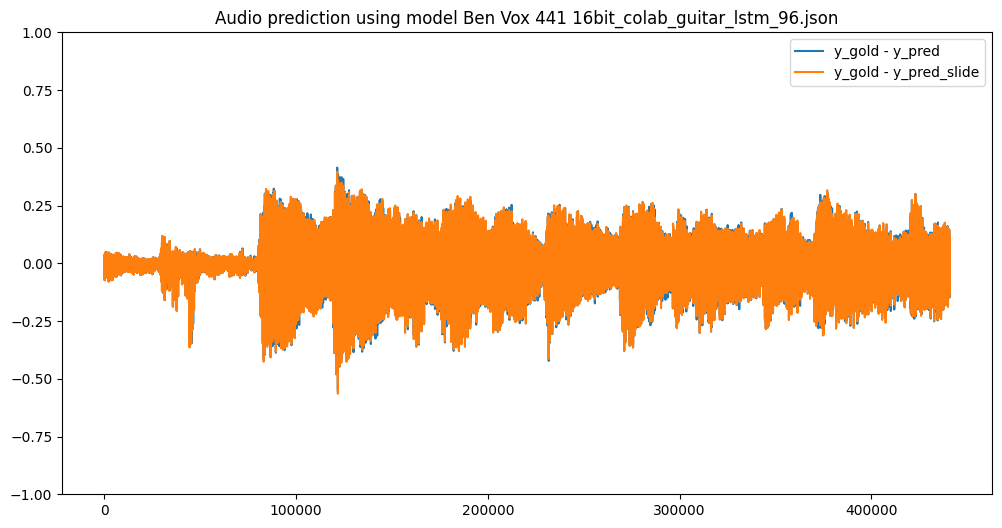

In [56]:
# plot x and y
y_pred_size = y_pred.shape[1]
y_pred_flat = y_pred.flatten()
plt.figure(figsize=(12, 6))
# plt.plot(x_all, label='x')
# plt.plot(y_gold[:y_pred_size], label='y_gold')
# plt.plot(y_pred_flat, label='y_pred')
plt.plot(y_gold[:y_pred_size] - y_pred_flat, label='y_gold - y_pred')
plt.plot(y_gold[:y_pred_size] - y_pred_slide[:y_pred_size], label='y_gold - y_pred_slide')
plt.ylim(-1, 1)
plt.legend()
plt.title(f'Audio prediction using model {model_file}')
plt.show()

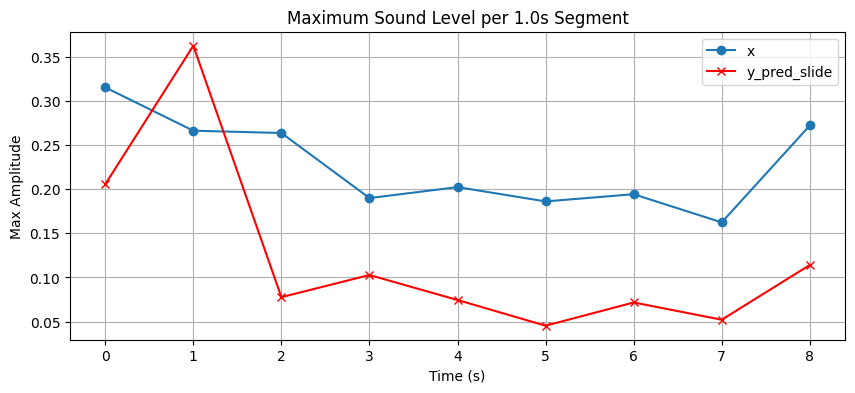

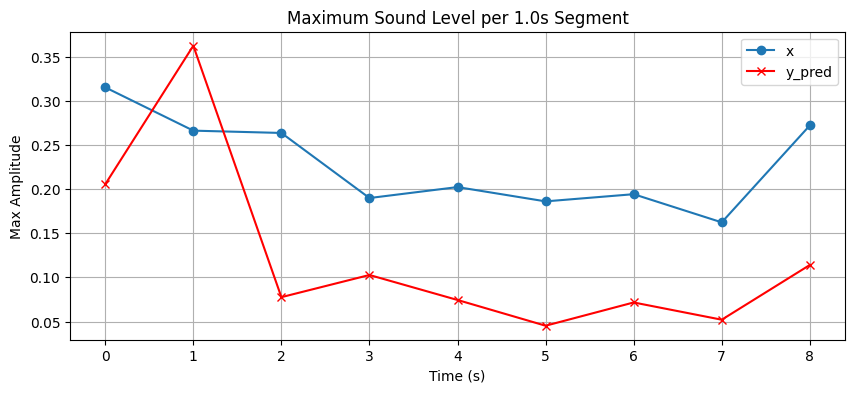

In [57]:
# viz_audio(y_gold[:y_pred_size], y_pred_flat, interval=1, sample_rate=sample_rate, x_legend='y_gold', y_legend='y_pred')
# viz audio original vs predictions
viz_audio(x_all, y_pred_slide, interval=1, sample_rate=sample_rate, x_legend='x', y_legend='y_pred_slide')
viz_audio(x_all, y_pred.flatten(), interval=1, sample_rate=sample_rate, x_legend='x', y_legend='y_pred')

In [58]:
# play audio
print("Original audio")
display(Audio(x_all, rate=sample_rate))
print("Predicted audio")
display(Audio(y_pred_flat, rate=sample_rate))
print("Predicted audio slide")
display(Audio(y_pred_slide, rate=sample_rate))
print("Gold audio")
display(Audio(y_gold[start_idx:start_idx+stop_idx], rate=sample_rate))


Original audio


Predicted audio


Predicted audio slide


Gold audio
